In this notebook, we introduce the search space of NAS for HyperTS.

In [1]:
import tensorflow as tf
from hypernets.searchers.random_searcher import RandomSearcher

from hyperts.framework.dl import layers
from hyperts.framework.search_space.micro_search_space import TSNASGenrealSearchSpace

#### 1. Load TSNAS search space

In [2]:
nas_search_space = TSNASGenrealSearchSpace(num_blocks=4, num_nodes=4, init_filters_or_units=64)
nas_search_space.update_init_params(task='forecast',
                                    timestamp='timestamp',
                                    metrics='accuracy',
                                    covariables=None,
                                    window=[3, 6, 9],
                                    horizon=1,
                                    freq='H')

#### 2. Init model

In [3]:
searcher = RandomSearcher(nas_search_space, optimize_direction='min')
space_sample = searcher.sample()
inp1 = layers.Input(shape=(4, 3))
inp2 = layers.Input(shape=(4, 5))
concat = layers.Concatenate()([inp1, inp2])
space, outputs = space_sample.compile_and_forward(concat)
model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=outputs[0])

#### 3. Summary model

In [4]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 5)]       0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4, 8)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
relay_input (Identity)          (None, 4, 8)         0           concatenate[0][0]     

#### 4. Plot network architecture

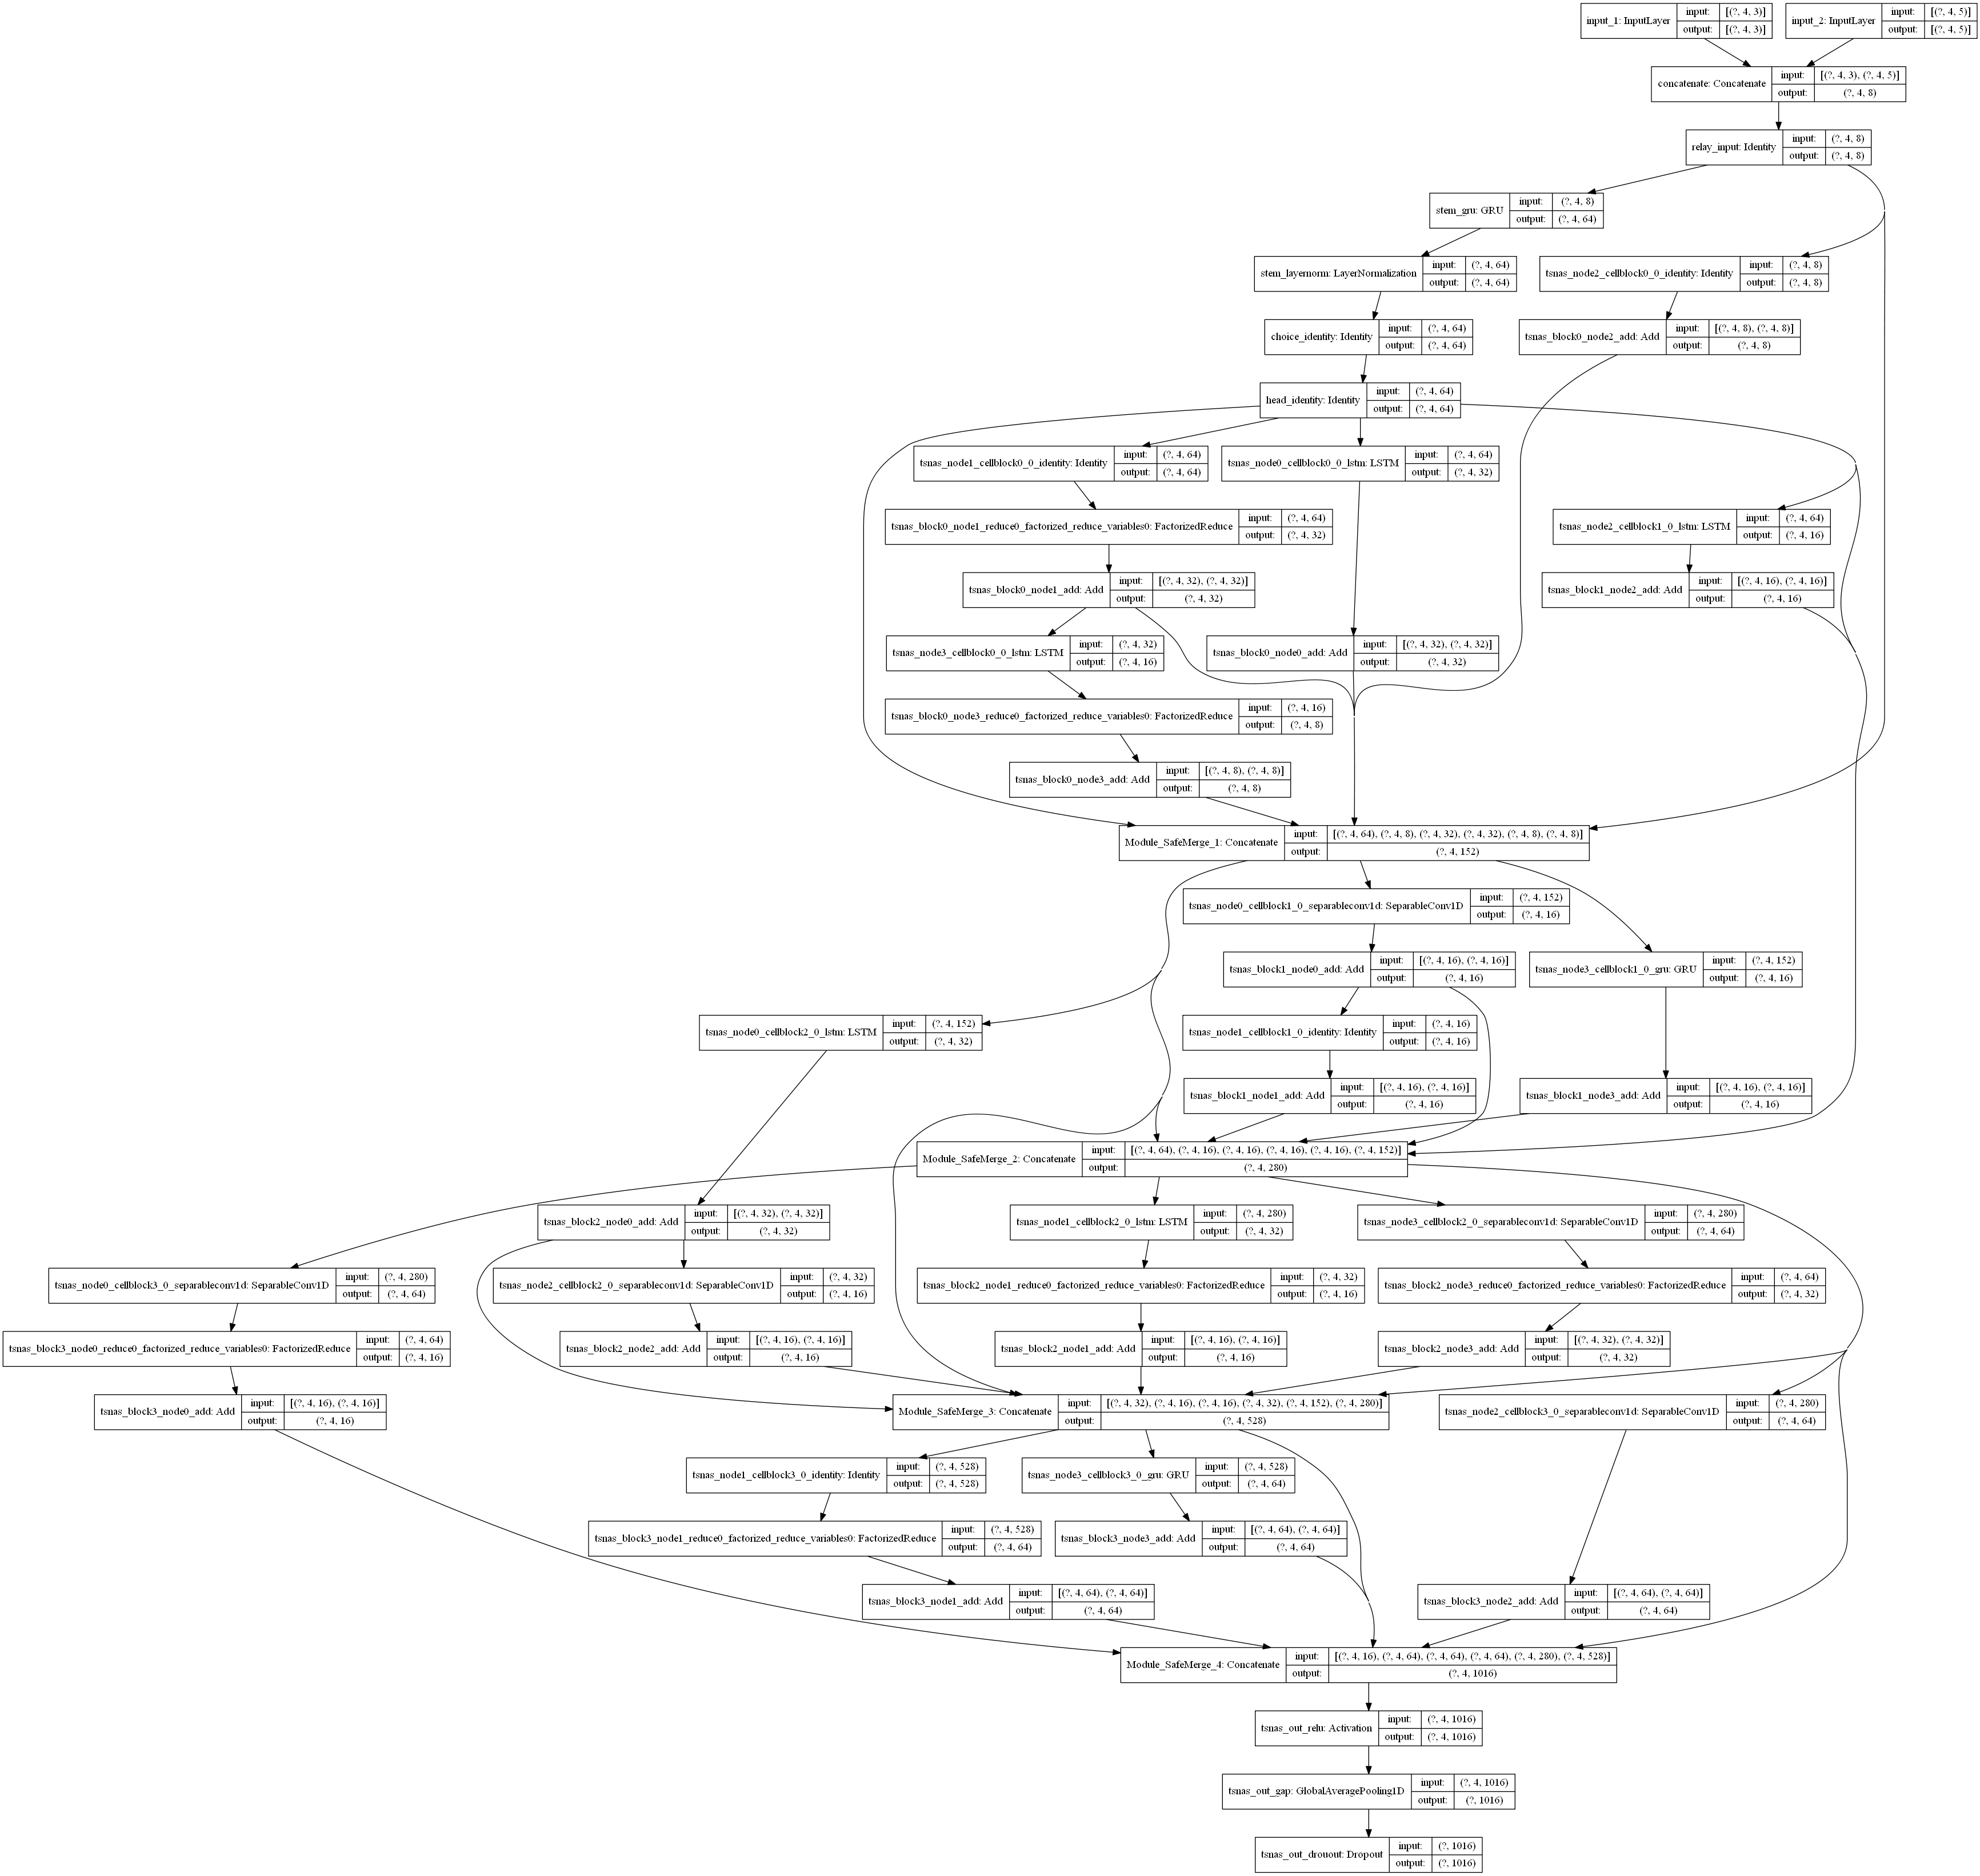

In [5]:
tf.keras.utils.plot_model(model, to_file='./images/tsnasmodel.png', show_shapes=True)

#### 5. Experiment

In [6]:
from hyperts import make_experiment
from hyperts.datasets import load_network_traffic
from sklearn.model_selection import train_test_split

In [7]:
data = load_network_traffic(univariate=True)
train_data, test_data = train_test_split(data, test_size=168, shuffle=False)

In [8]:
model = make_experiment(train_data.copy(),
                        task='forecast',
                        mode='nas',
                        tf_gpu_usage_strategy=1,
                        max_trials=1,
                        timestamp='TimeStamp',
                        covariates=['HourSin', 'WeekCos', 'CBWD']).run()

In [9]:
X_test, y_test = model.split_X_y(test_data.copy())

In [10]:
y_pred = model.predict(X_test)

In [11]:
scores = model.evaluate(y_test, y_pred)
scores

,Metirc,Score
0,mae,1.6995
1,mse,6.3345
2,rmse,2.5169
3,mape,0.2021
4,smape,0.1949


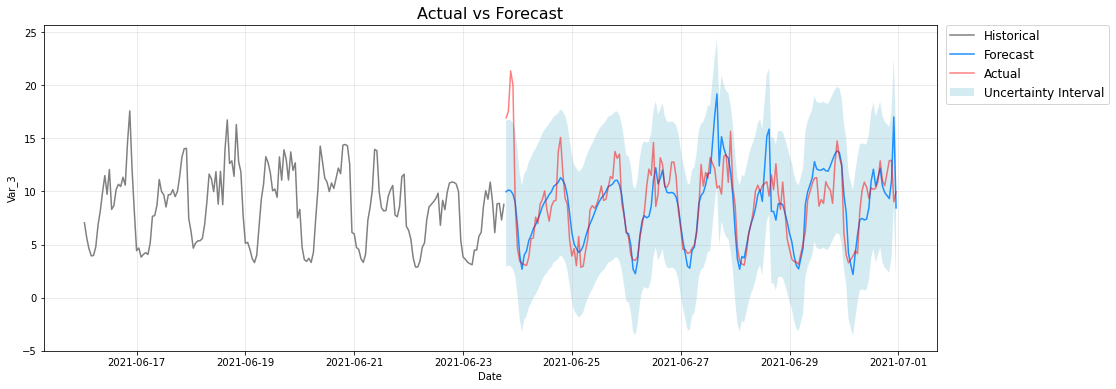

In [12]:
model.plot(forecast=y_pred, actual=test_data, interactive=False)